## Step Size, Convergence of MCMC

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize']=(10,8)
plt.rcParams['axes.grid']= True

#### **In this article, I would discuss the step size of MCMC and its convergence.**

MCMC is a kind of random walk algorithm. Due to law of large number, MCMC eventually converges to a distrition $p(x)$ from which we are desired to sample. But it do not tell us how long it will converge. Actually, the time of convergence is depend on the step size of MCMC. This also is a limitation of MCMC because **MCMC is very sensitive to step size.** 

**What's the step size?**  For example, assume the proposed distribution is gaussian distribution, the step size is variance. Variance can be viewed as the scale that we exploit in the functional space. Also, step size will affect the time of convergence. **Large step size can help MCMC converge faster but it will ignored many detail and go outside of support, which will leads to many rejection. Small step size will takes us a long time to converge and more acceptence will happen.**(I will use an example to illustrate this concept, this example is from [course AM207](https://am207.github.io/2017/wiki/convergenceandcoverage.html))

Obviously, at the beginning, MCMC do not converge and MCMC sample will have high autocorrelation. **Why is autocorrelation bad in MCMC?** MCMC samples are from the $p(x)$ and are gauranteed to be **act as IID** due to the "ergodic" law of large numbers: time averages can be used as sample averages.**How to reduce autocorrelation?** **Burn-in** and **thining** are commom mehtods to do so.

**What's burn-in?** "Burn-in" descirbes the practics of throwing away some samples at the beginning of iteration in MCMC.

**What's the thining?** From the perspective of signal processing, it is uniform downsampling.

Here, I will show you an example to illustrate these concepts from [course AM207](https://am207.github.io/2017/wiki/convergenceandcoverage.html).

In [15]:
## Code of Metropolis Algorithm
def metropolis(p, qdraw, step_size, num_samples, x_init):
    x_prev = x_init
    samples = np.zeros(num_samples)
    accepted = 0
    for i in range(0, num_samples):
        x_star = qdraw(x_prev, step_size)
        p_star = p(x_star)
        p_prev = p(x_prev)
        pdfratio = p_star/p_prev
        if np.random.uniform() < min(1, pdfratio):
            samples[i] = x_star
            x_prev = x_star
            accepted += 1
        else:
            samples[i] = x_prev
    return samples, accepted

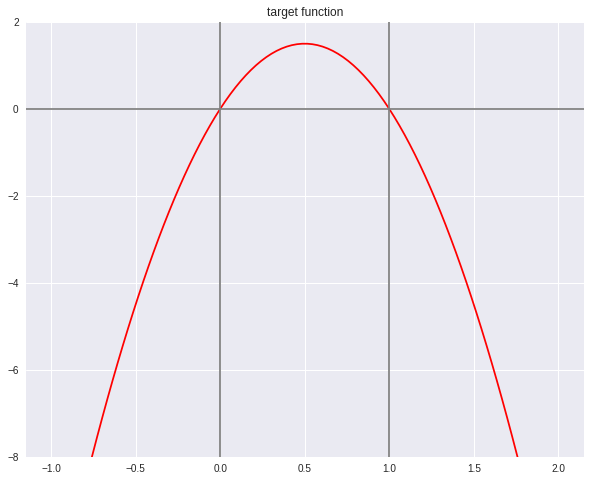

In [67]:
## target function
f = lambda x: x*6*(1-x)

x = np.linspace(-1, 2, 100)
plt.plot(x, f(x), 'r')

plt.axvline(0, 0, 1, color='gray')
plt.axvline(1, 0, 1, color='gray')
plt.axhline(0, 0, 1, color='gray')
plt.ylim([-8,2])
plt.title('target function')

Assume we consider the support $[0,1]$, we can truncate the domain even though we propose normal distribution which can propose negative sample and great-than-one x values.

What happen if the proposal proposes a number outside of $[0,1]$? That is easy to solve it. In Metropolis formula, we could check if uniform is less than a negative or 0 number and we will not accept. This means that we need a longer set in MCMC.

### Proposed Ditribution

In [17]:
def prop(x, step_size):
    return np.random.normal(x, step_size)

## Resoneable step size

('starting point is : ', 0.775499419960127, ' the acceptance ratio is ', 0.4357)


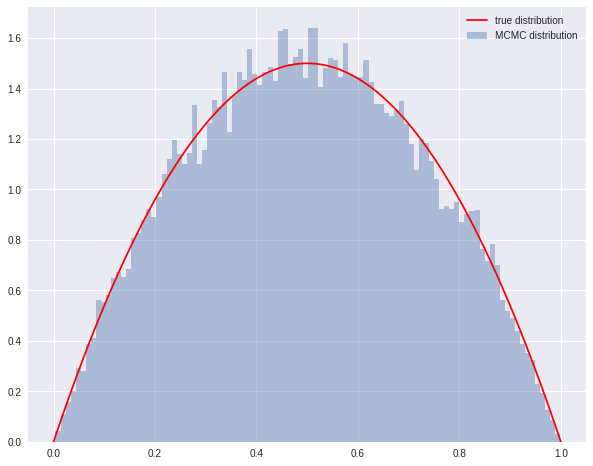

In [68]:
x_init = np.random.uniform()
num_samples = 100000
samples, acc = metropolis(f, prop, 0.6, num_samples, x_init)

## we throw away 20% samples
burnin = int(num_samples*0.2)

## plot MCMC distribution
plt.hist(samples[burnin:], bins=100, alpha=0.4, label='MCMC distribution', normed=True)
## plot true distributin
xx = np.linspace(0, 1, 100)
plt.plot(xx, f(xx), 'r', label='true distribution')
plt.legend()

print('starting point is : ', x_init, ' the acceptance ratio is ', (float(acc)/num_samples))

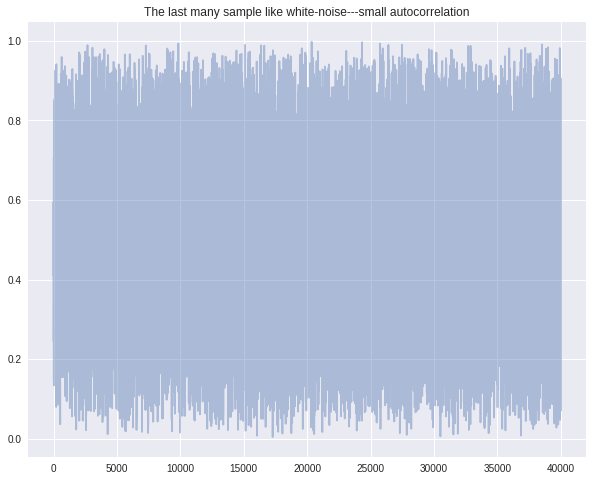

In [69]:
plt.plot(samples[-2*burnin:], alpha=0.4)
plt.title('The last many sample like white-noise---small autocorrelation')

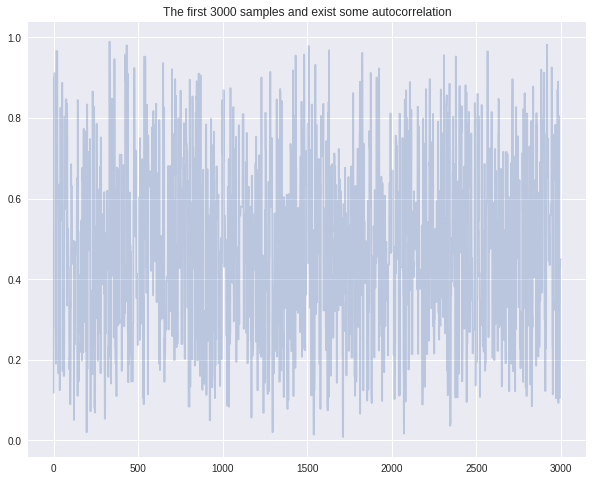

In [70]:
plt.plot(samples[:3000], alpha=0.3)
plt.title('The first 3000 samples and exist some autocorrelation')

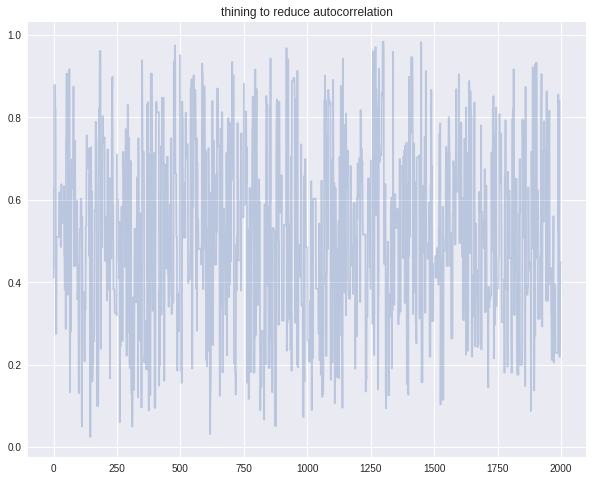

In [71]:
plt.plot(samples[burnin:burnin+burnin//10], alpha=0.3)
plt.title('thining to reduce autocorrelation')

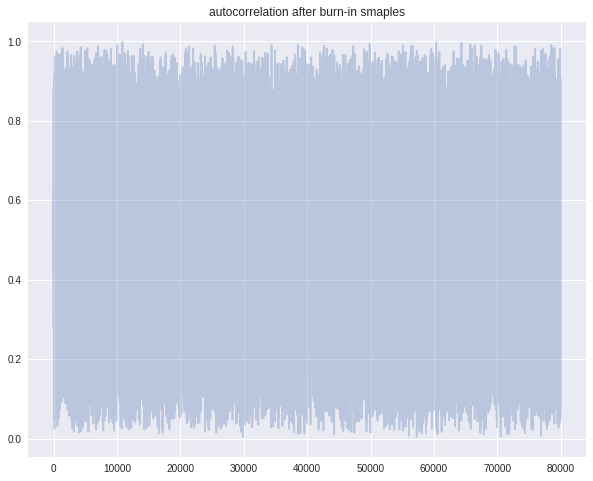

In [72]:
plt.plot(samples[burnin:], alpha=0.3)
plt.title('autocorrelation after burn-in smaples')

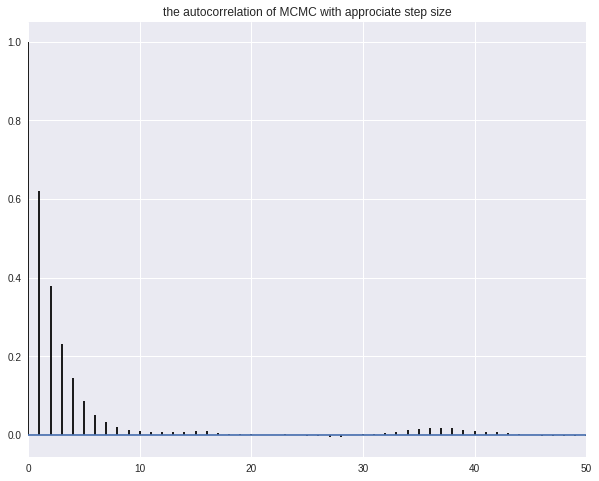

In [73]:
def corrplot(samples, maxlags=50):
    plt.acorr(samples-np.mean(samples), normed=True, maxlags=maxlags)
    plt.xlim([0, maxlags])

corrplot(samples)
plt.title('the autocorrelation of MCMC with approciate step size')

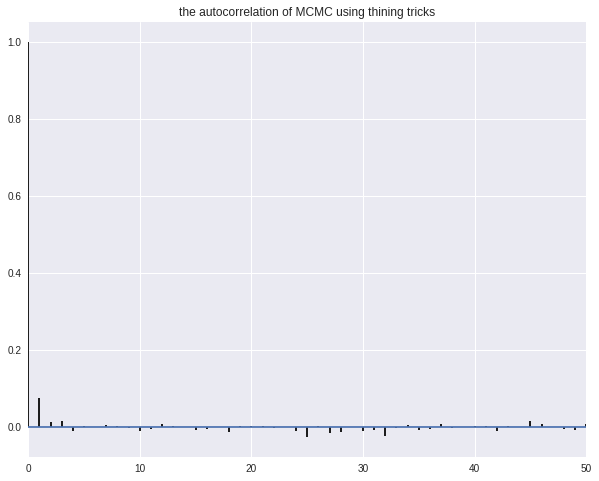

In [74]:
thin = 5
samples_thin = samples[burnin::5]
corrplot(samples_thin)
plt.title('the autocorrelation of MCMC using thining tricks')

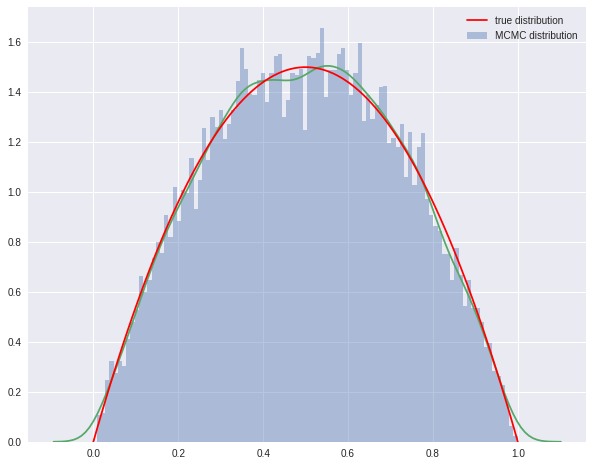

In [45]:
## plot MCMC distribution
plt.hist(samples_thin, bins=100, alpha=0.4, label='MCMC distribution', normed=True)
sns.kdeplot(samples_thin)
## plot true distributin
xx = np.linspace(0, 1, 100)
plt.plot(xx, f(xx), 'r', label='true distribution')
plt.legend()

### How about the large step size?

If our proposal is gaussian distribution, $\sigma$ is the parameter control the step size. A large sigma leads to fast convergence, but we will miss out details. Because we propose a lot of moves that probability changes frequently, thus we will have many rejection. 

<img src="https://am207.github.io/2017/wiki/images/largestep.png" width = "600" height = "400" alt="Large Step Size" />

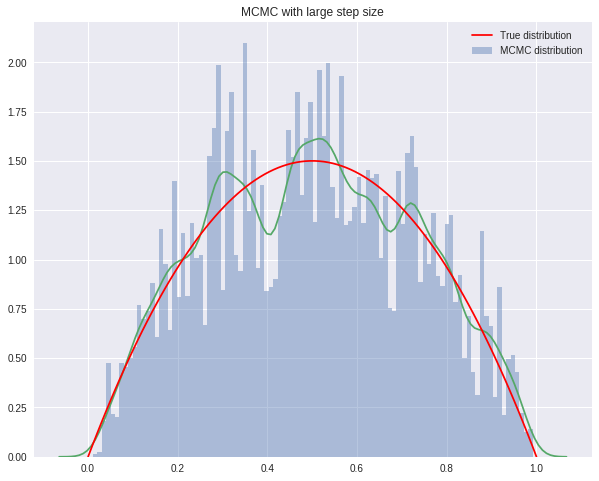

('starting point was ', 0.9236698605699044, 'accepted', 0.02973)


In [58]:
samps2, acc2 = metropolis(f, prop, 10.0, num_samples, x_init)
plt.hist(samps2[burnin:],bins=100, alpha=0.4, label=u'MCMC distribution', normed=True)
sns.kdeplot(samps2[burnin:])
#plot the true function
xx= np.linspace(0,1,100)
plt.plot(xx, f(xx), 'r', label=u'True distribution') 
plt.legend()
plt.title('MCMC with large step size')
plt.show()
print("starting point was ", x_init, "accepted", float(acc2)/num_samples)

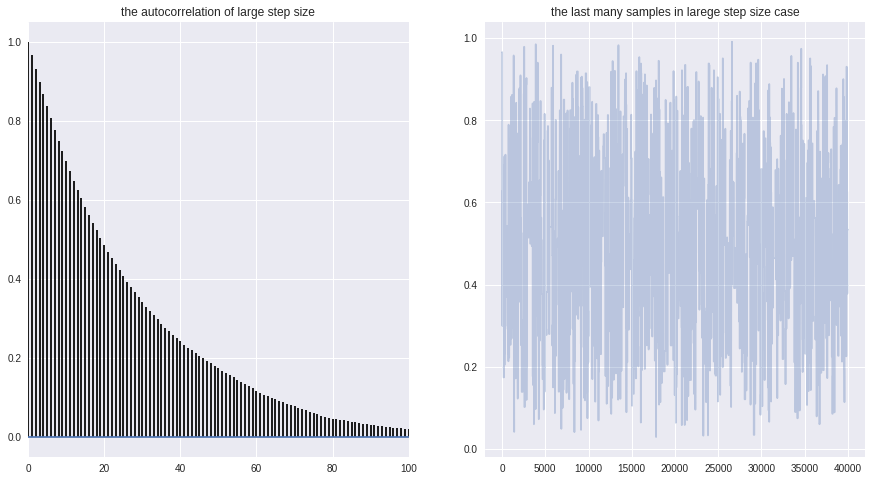

In [63]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
corrplot(samps2[burnin:],100)
plt.title('the autocorrelation of large step size')
plt.subplot(1,2,2)
plt.plot(samps2[-2*burnin:], alpha=0.3);
plt.title('the last many samples in larege step size case')

### How about small size?

A small $\sigma$ corresponds to a smaller step size, and thus our sampler takes longer. But because we make only small changes in probability, our acceptance ration will be high!

<img src="https://am207.github.io/2017/wiki/images/smallstep.png" width = "600" height = "400" alt="Large Step Size" />

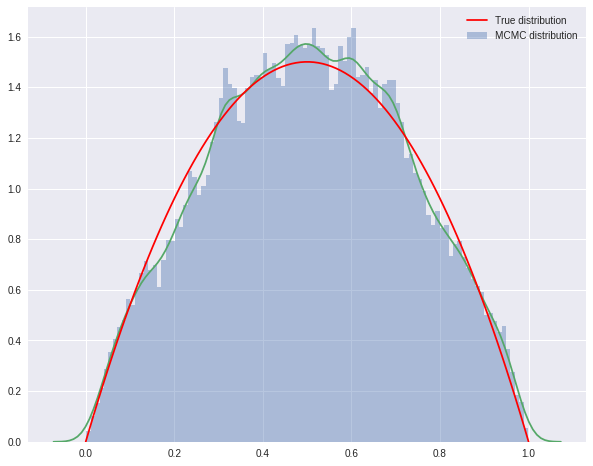

('starting point was ', 0.9236698605699044, 'accepted', 0)


In [65]:
samps3, acc3 = metropolis(f, prop, 0.01, num_samples, x_init)
# plot our sample histogram
plt.hist(samps3[burnin:],bins=100, alpha=0.4, label=u'MCMC distribution', normed=True)
sns.kdeplot(samps3[burnin:])
#plot the true function
xx= np.linspace(0,1,100)
plt.plot(xx, f(xx), 'r', label=u'True distribution') 
plt.legend()

plt.show()
print("starting point was ", x_init, "accepted", acc3/num_samples)

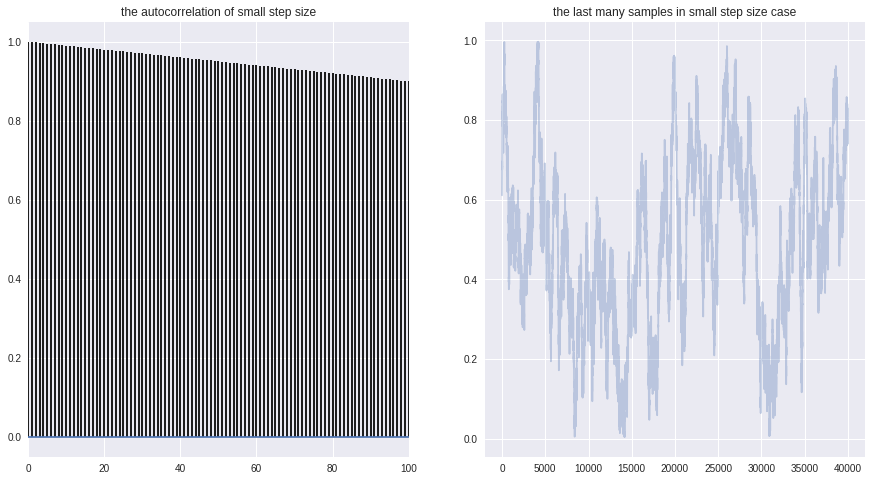

In [66]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
corrplot(samps3[burnin:],100)
plt.title('the autocorrelation of small step size')
plt.subplot(1,2,2)
plt.plot(samps3[-2*burnin:], alpha=0.3);
plt.title('the last many samples in small step size case')

## Mixing and Convergence

Mixing is about how well we cover the relevant space. Convergence is “are we there yet?” where by there we mean at the stationary distribution. Good mixing leads to faster convergence.

We do know that our sequence will converge as $n\rightarrow \infty$. But we dont want to be around, waiting for a very long time. And we dont know how many iterations it will take.

** We need to test for convergence **

This is just a lab. We will come to formal tests in a subsequent lecture, but currently let us look at some heuristics to build intution.

### Trace Plots

Trace plots are very useful for visual inspection. You should be able to see the burnin period, and then the chain produce something that looks like white noise.

**Inspecting the trace plot can show when we have not converged yet**. You will see large movements and regions of stasis where the autocorrelation is large. On the other hand, remember that without any formal tests, the traceplot cannot show for sure that we have converged either.

Some possibly useful visualizations:

- look at the whole plot
- divide into subsets of few 100s or few 1000s of samples and compare histograms/kdeplots
- start multiple different chains from random start points and compare the traceplots

### Autocorrelation

Autocorrelation can be a good diagnostic. After the burnin, the autocorrelation should decay within a few lags if we have reached ergodicity. There will likely still be some autocorrelation left. MCMC samples are samples from $p(x)$ and are guaranteed to be **act as IID**  due to the "ergodic" law of large numbers: time averages can be used as sample averages. But nearby samples are not *IID*, and you can help them along by shuffling the samples, or thinning so the the autocorrelation becomes minimal.